In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import lightgbm as lgb

In [46]:
df = pd.read_csv("train.csv", parse_dates=["date"])
df = df[df["num_sold"].notna()]

In [47]:
def x_transform(df, scaler, train):
    df["date"] = (df["date"] - df["date"].min()).dt.days
    if train:
        df["date"] = scaler.fit_transform(df["date"].to_numpy().reshape(-1, 1))
    else: 
        df["date"] = scaler.transform(df["date"].to_numpy().reshape(-1, 1))
    df = pd.get_dummies(df, dtype=int)
    return df

def y_transform(series, scaler, train):
    series = np.log(series.to_numpy())
    series = series.reshape(-1, 1)
    if train:
        scaler.fit_transform(series)
    else:
        scaler.transform(series)
    return series

def inverse_transform(series, scaler):
    series = np.array(series).reshape(-1, 1)
    series = scaler.inverse_transform(series)
    series = np.exp(series)
    return series

In [48]:
train = df.sample(frac=0.8, random_state=42)
test = df.drop(train.index)
X_train, y_train = train.drop(["num_sold", "id"], axis=1), train["num_sold"]
X_test, y_test = test.drop(["num_sold", "id"], axis=1), test["num_sold"]

In [19]:
params = {
    "task": "train",
    "boosting": "gbdt",
    "objective": "mape",
    "metric": "mape",
    "verbose": -1
}

In [56]:
from sklearn.preprocessing import StandardScaler

date_scaler = StandardScaler()
X_train = x_transform(X_train, date_scaler, train=True)
X_test = x_transform(X_test, date_scaler, train=False)

y_scaler = StandardScaler()
y_train = y_transform(y_train, y_scaler, train=True)

In [21]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [22]:
model = lgb.train(params,
                  train_set=lgb_train,
                  valid_sets=lgb_eval)

d:\Users\semic\Anaconda3\envs\qfi\Lib\site-packages\lightgbm\basic.py:357: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")
d:\Users\semic\Anaconda3\envs\qfi\Lib\site-packages\lightgbm\basic.py:357: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")


In [37]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.model_selection import RandomizedSearchCV

cv_model = LGBMRegressor()

param_grid = {
    'num_leaves': [20, 31, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'max_depth': [-1, 10, 20],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

random_search = RandomizedSearchCV(estimator=cv_model,
                                   param_distributions=param_grid,
                                   scoring=mape,
                                   n_iter=50,  # Number of random samples to evaluate
                                   cv=5,
                                   verbose=2,
                                   random_state=42)

In [38]:
type(cv_model)

lightgbm.sklearn.LGBMRegressor

In [ ]:
random_search.fit(X_train, y_train)

In [40]:
random_search.best_estimator_

LGBMRegressor(colsample_bytree=0.8, max_depth=20, n_estimators=200,
              num_leaves=20, subsample=0.6)

In [57]:
random_search.predict(X_test)

array([7.39487902, 7.53423851, 6.64546026, ..., 6.17398604, 6.88473254,
       5.87222631])

In [52]:
y_test.to_numpy()

array([1837., 2212.,  926., ...,  556., 1052.,  466.])

In [58]:
y_pred = np.exp(random_search.predict(X_test))
mape(y_test, y_pred)

0.08236973873808207

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

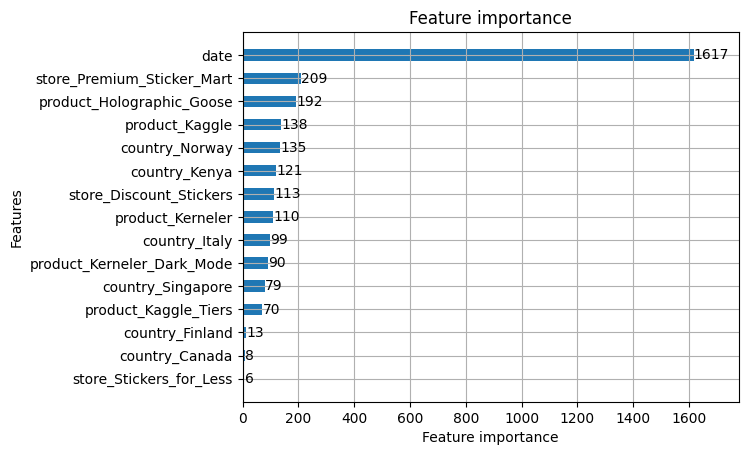

In [59]:
lgb.plot_importance(model, height=0.5)

In [60]:
test_df = pd.read_csv('test.csv', parse_dates=['date'])
test_df.head(2)

,id,date,country,store,product
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle


In [61]:
df["date"] = (df["date"] - df["date"].min()).dt.days

In [62]:
date_scaler.fit(df["date"].to_numpy().reshape(-1, 1))
test = x_transform(test_df.drop("id", axis=1), date_scaler, train=False)
test.head(2)

,date,country_Canada,country_Finland,country_Italy,country_Kenya,country_Norway,country_Singapore,store_Discount Stickers,store_Premium Sticker Mart,store_Stickers for Less,product_Holographic Goose,product_Kaggle,product_Kaggle Tiers,product_Kerneler,product_Kerneler Dark Mode
0,-1.739478,1,0,0,0,0,0,1,0,0,1,0,0,0,0
1,-1.739478,1,0,0,0,0,0,1,0,0,0,1,0,0,0


In [64]:
final_pred = random_search.predict(test)
submission4 = pd.DataFrame({"id": test_df["id"], "num_sold": np.exp(final_pred).flatten()})
submission4.to_csv("submission4.csv", index=False)